**Gold is a precious metal symbolized as Au, cherished for its historical and cultural significance, often used in jewellery and art. It serves as a store of value and is a safe-haven asset in times of economic uncertainty, with its price influenced by global factors
In this project we aim to utilise the Long Short-Term Memory(LSTM) to forecast the direction of price movements in financial markets, specifically whether prices would rise or fall the following day.
I got the data from the yahoo finance through the yfinance library. The data consisted  of the following columns namely  Open,High,Low,Close,Adj Close and Volume.**


**Importing relevant libraries**

In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install yfinance
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error

In [439]:
data= yf.download('GC=F')

[*********************100%%**********************]  1 of 1 completed


In [440]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...,...
2023-09-20,1945.599976,1945.599976,1929.199951,1945.599976,1945.599976,119
2023-09-21,1924.000000,1924.000000,1919.199951,1919.199951,1919.199951,9
2023-09-22,1925.400024,1925.400024,1925.400024,1925.400024,1925.400024,1


**VISUALIZATION**

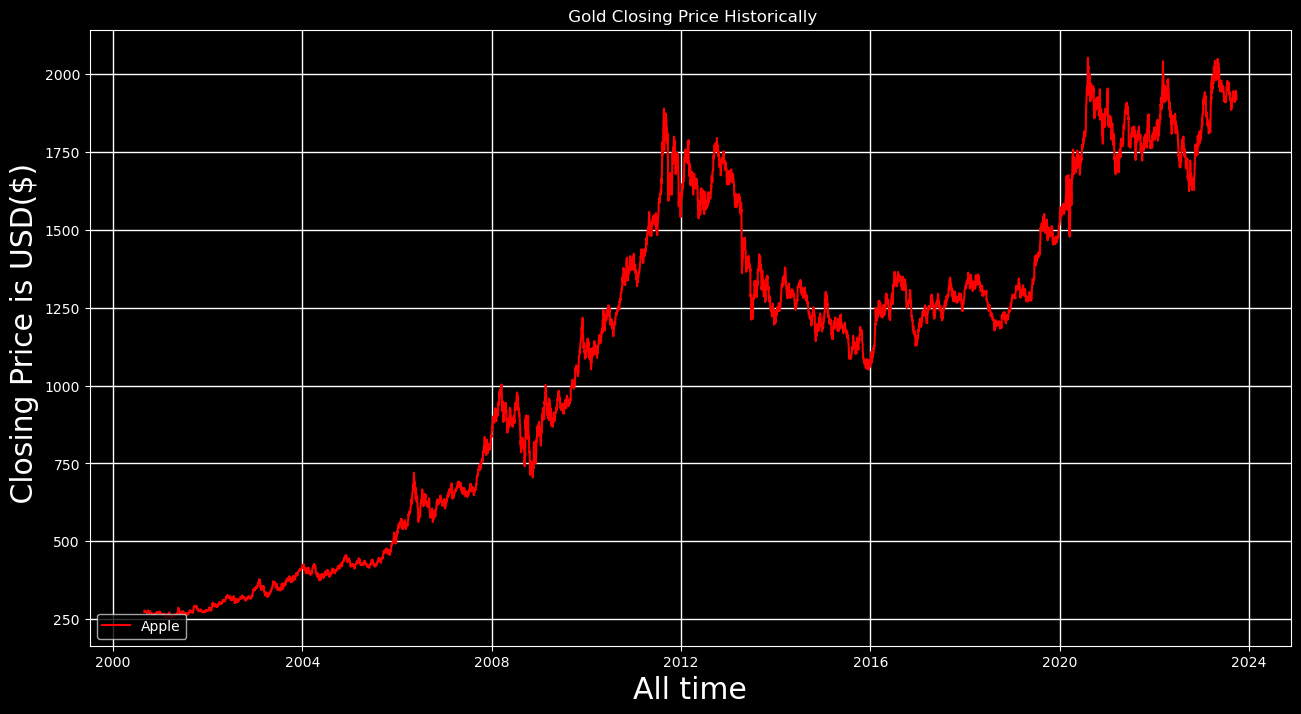

In [441]:
plt.style.use('dark_background')


plt.figure(figsize=(15.5,8))
plt.plot(data['Close'],color='red', label='Apple')
plt.grid(linewidth='1',color='white')
plt.title(' Gold Closing Price Historically')
plt.xlabel("All time",fontsize=21.5)
plt.ylabel(" Closing Price is USD($)",fontsize=21.5)
plt.legend(loc="lower left")
plt.show()

**Visualizing the distribution of the data**

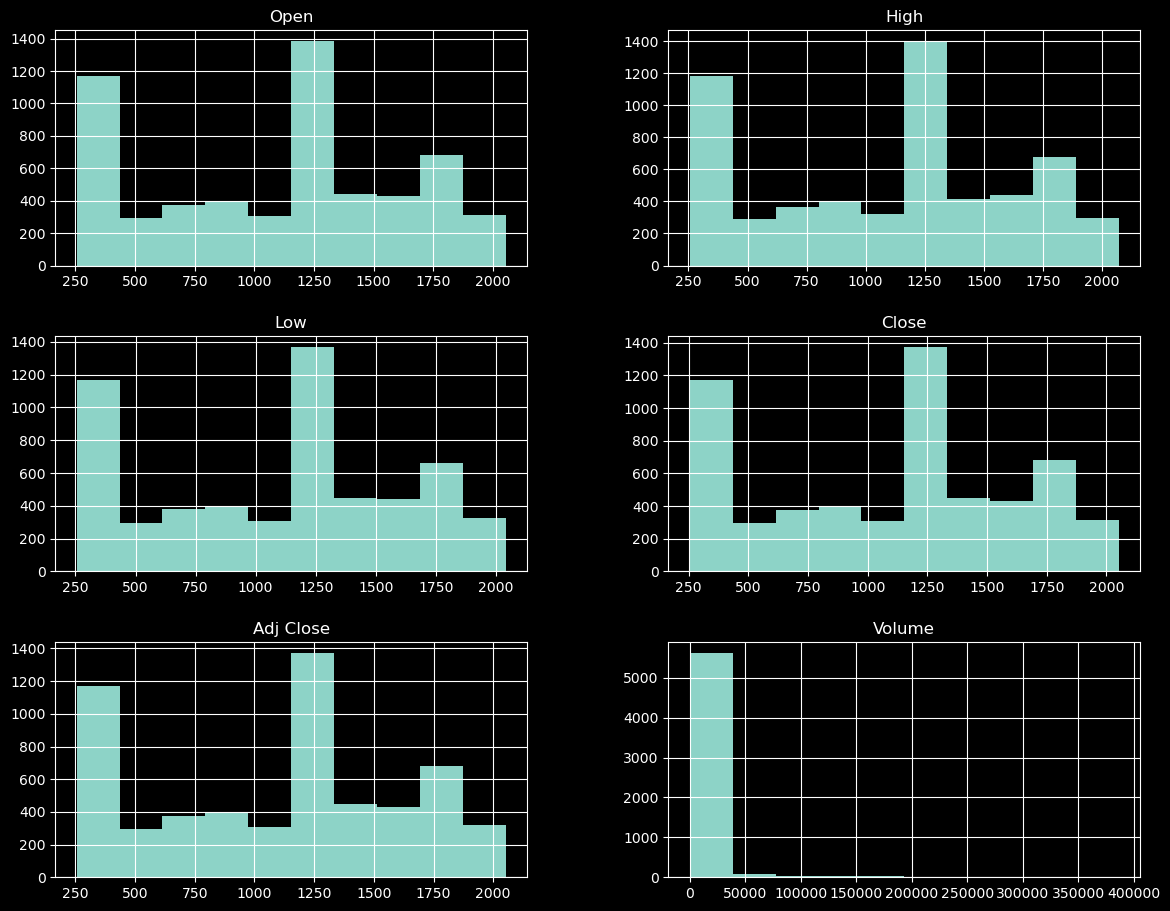

In [442]:
data.hist(figsize=(14,11))
plt.show()

In [443]:
data.corr()["Close"].sort_values(ascending=False)

Close        1.000000
Adj Close    1.000000
Low          0.999901
High         0.999874
Open         0.999776
Volume       0.054262
Name: Close, dtype: float64

In [444]:
data['Date'] = pd.to_datetime(data.index)

In [445]:
data.index

DatetimeIndex(['2000-08-30', '2000-08-31', '2000-09-01', '2000-09-05',
               '2000-09-06', '2000-09-07', '2000-09-08', '2000-09-11',
               '2000-09-12', '2000-09-13',
               ...
               '2023-09-13', '2023-09-14', '2023-09-15', '2023-09-18',
               '2023-09-19', '2023-09-20', '2023-09-21', '2023-09-22',
               '2023-09-25', '2023-09-26'],
              dtype='datetime64[ns]', name='Date', length=5788, freq=None)

**Feature Engineeing**

In [446]:
data["next_closing_price"]=data["Close"].shift(-1)

In [447]:
# Calculating the Average Price
data['Average Price'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

# Calculating  the Price Spread as a percentage of the 'Open' price
data['Price Spread (%)'] = ((data['High'] - data['Low']) / data['Open']) * 100

In [448]:
window = 4  
data['Close_Std_Dev'] = data['Close'].rolling(window=window).std()

In [449]:
def create_features(data):
    data=data.copy()
    data['day of week']=data.index.dayofweek
    data['quarter']=data.index.quarter
    data['month']=data.index.month
    data['year']=data.index.year
    data['dayofyear']=data.index.dayofyear
    
    return data

In [450]:
data=create_features(data)

In [451]:
data["target"]=(data["next_closing_price"]> data["Close"]).astype(int)

In [452]:
data = pd.DataFrame(data)

# Calculating price changes
data['Price Change'] = data['Close'].diff()

# Separating  gains and losses
data['Gain'] = data['Price Change'].apply(lambda x: x if x > 0 else 0)
data['Loss'] = -data['Price Change'].apply(lambda x: x if x < 0 else 0)

# average gain and average loss over 7 days
period = 7
data['Avg Gain'] = data['Gain'].rolling(window=period).mean()
data['Avg Loss'] = data['Loss'].rolling(window=period).mean()

# Calculating  relative strength (RS)
data['RS'] = data['Avg Gain'] / data['Avg Loss']

# Calculating RSI
data['RSI'] = 100 - (100 / (1 + data['RS']))

In [453]:
data

,Open,High,Low,Close,Adj Close,Volume,Date,next_closing_price,Average Price,Price Spread (%),...,year,dayofyear,target,Price Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0,2000-08-30,278.299988,273.899994,0.000000,...,2000,243,1,NaN,0.000000,-0.000000,NaN,NaN,NaN,NaN
2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0,2000-08-31,277.000000,276.549988,1.273654,...,2000,244,0,4.399994,4.399994,-0.000000,NaN,NaN,NaN,NaN
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0,2000-09-01,275.799988,277.000000,0.000000,...,2000,245,0,-1.299988,0.000000,1.299988,NaN,NaN,NaN,NaN
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2,2000-09-05,274.200012,275.799988,0.000000,...,2000,249,0,-1.200012,0.000000,1.200012,NaN,NaN,NaN,NaN
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0,2000-09-06,274.000000,274.200012,0.000000,...,2000,250,0,-1.599976,0.000000,1.599976,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,1945.599976,1945.599976,1929.199951,1945.599976,1945.599976,119,2023-09-20,1919.199951,1941.499969,0.842929,...,2023,263,0,13.599976,13.599976,-0.000000,5.214286,2.028582,2.570409,71.992006
2023-09-21,1924.000000,1924.000000,1919.199951,1919.199951,1919.199951,9,2023-09-21,1925.400024,1921.599976,0.249483,...,2023,264,1,-26.400024,0.000000,26.400024,5.214286,4.085728,1.276219,56.067504
2023-09-22,1925.400024,1925.400024,1925.400024,1925.400024,1925.400024,1,2023-09-22,1916.599976,1925.400024,0.000000,...,2023,265,0,6.200073,6.200073,-0.000000,6.100010,3.771432,1.617426,61.794519


In [454]:
data.pop('Date')

Date
2000-08-30   2000-08-30
2000-08-31   2000-08-31
2000-09-01   2000-09-01
2000-09-05   2000-09-05
2000-09-06   2000-09-06
                ...    
2023-09-20   2023-09-20
2023-09-21   2023-09-21
2023-09-22   2023-09-22
2023-09-25   2023-09-25
2023-09-26   2023-09-26
Name: Date, Length: 5788, dtype: datetime64[ns]

In [455]:
data

,Open,High,Low,Close,Adj Close,Volume,next_closing_price,Average Price,Price Spread (%),Close_Std_Dev,...,year,dayofyear,target,Price Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0,278.299988,273.899994,0.000000,NaN,...,2000,243,1,NaN,0.000000,-0.000000,NaN,NaN,NaN,NaN
2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0,277.000000,276.549988,1.273654,NaN,...,2000,244,0,4.399994,4.399994,-0.000000,NaN,NaN,NaN,NaN
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0,275.799988,277.000000,0.000000,NaN,...,2000,245,0,-1.299988,0.000000,1.299988,NaN,NaN,NaN,NaN
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2,274.200012,275.799988,0.000000,1.869937,...,2000,249,0,-1.200012,0.000000,1.200012,NaN,NaN,NaN,NaN
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0,274.000000,274.200012,0.000000,1.746178,...,2000,250,0,-1.599976,0.000000,1.599976,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,1945.599976,1945.599976,1929.199951,1945.599976,1945.599976,119,1919.199951,1941.499969,0.842929,9.098357,...,2023,263,0,13.599976,13.599976,-0.000000,5.214286,2.028582,2.570409,71.992006
2023-09-21,1924.000000,1924.000000,1919.199951,1919.199951,1919.199951,9,1925.400024,1921.599976,0.249483,10.786227,...,2023,264,1,-26.400024,0.000000,26.400024,5.214286,4.085728,1.276219,56.067504
2023-09-22,1925.400024,1925.400024,1925.400024,1925.400024,1925.400024,1,1916.599976,1925.400024,0.000000,11.312974,...,2023,265,0,6.200073,6.200073,-0.000000,6.100010,3.771432,1.617426,61.794519


In [456]:
data['Close_Std_Dev'].fillna(0, inplace=True)

**Heatmap plot  of all the features**

<Axes: >

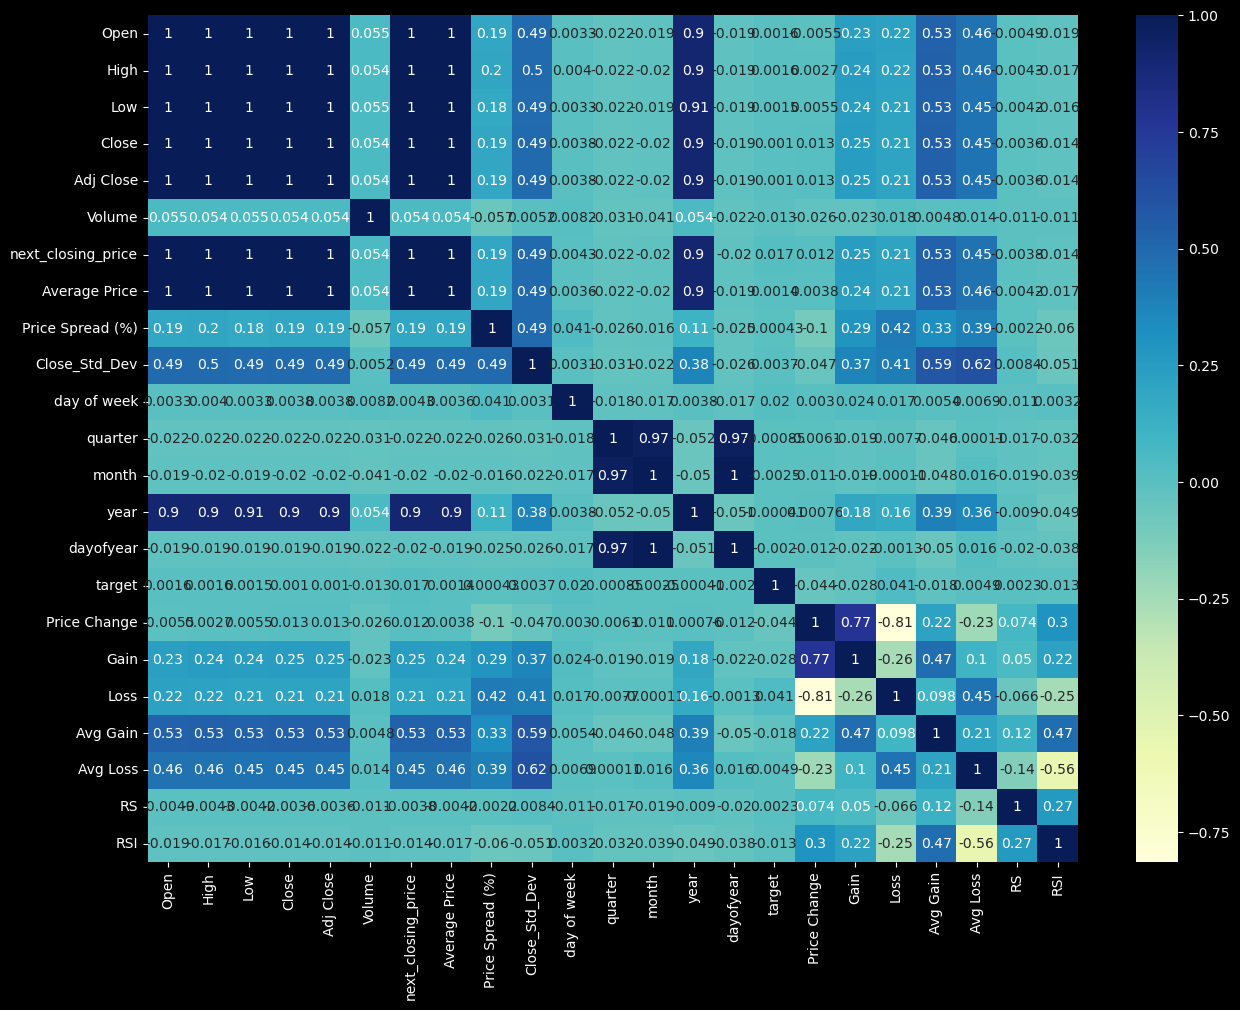

In [457]:
plt.figure(figsize=(15,11))
sns.heatmap(data.corr(), cmap="YlGnBu" ,annot=True) 

In [458]:
data = data.dropna()

In [459]:
data

,Open,High,Low,Close,Adj Close,Volume,next_closing_price,Average Price,Price Spread (%),Close_Std_Dev,...,year,dayofyear,target,Price Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2000-09-08,273.299988,273.299988,273.299988,273.299988,273.299988,0,273.100006,273.299988,0.000000,1.056328,...,2000,252,0,-0.700012,0.000000,0.700012,0.628571,0.714286,0.879999,46.808476
2000-09-11,273.100006,273.100006,273.100006,273.100006,273.100006,0,272.899994,273.100006,0.000000,0.532295,...,2000,255,0,-0.199982,0.000000,0.199982,0.628571,0.742855,0.846156,45.833386
2000-09-12,272.899994,272.899994,272.899994,272.899994,272.899994,0,272.799988,272.899994,0.000000,0.478715,...,2000,256,0,-0.200012,0.000000,0.200012,0.000000,0.771428,0.000000,0.000000
2000-09-13,272.799988,272.799988,272.799988,272.799988,272.799988,0,272.399994,272.799988,0.000000,0.221736,...,2000,257,0,-0.100006,0.000000,0.100006,0.000000,0.600002,0.000000,0.000000
2000-09-14,272.399994,272.399994,272.399994,272.399994,272.399994,0,272.299988,272.399994,0.000000,0.294396,...,2000,258,0,-0.399994,0.000000,0.399994,0.000000,0.485713,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19,1934.000000,1934.000000,1932.000000,1932.000000,1932.000000,6,1945.599976,1933.000000,0.103413,10.262879,...,2023,262,1,0.500000,0.500000,-0.000000,3.971436,2.028582,1.957740,66.190400
2023-09-20,1945.599976,1945.599976,1929.199951,1945.599976,1945.599976,119,1919.199951,1941.499969,0.842929,9.098357,...,2023,263,0,13.599976,13.599976,-0.000000,5.214286,2.028582,2.570409,71.992006
2023-09-21,1924.000000,1924.000000,1919.199951,1919.199951,1919.199951,9,1925.400024,1921.599976,0.249483,10.786227,...,2023,264,1,-26.400024,0.000000,26.400024,5.214286,4.085728,1.276219,56.067504


In [460]:

# Separating features (X) and target variable (y)
X = data[['Open', 'High', 'Low', 'Close', 'Volume','Average Price','Price Spread (%)','Close_Std_Dev','day of week','quarter','month','year','dayofyear','RSI']]
y = data['target']

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [461]:
scaler = StandardScaler()

# Fitting  and transforming  the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transforming the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Defining  the number of time steps (timesteps)
timesteps = 7

# Reshaping the data into the required 3D format
X_train_3d = []
X_test_3d = []

# Creating sequences for training data
for i in range(timesteps, len(X_train_scaled) - 1):
    X_train_3d.append(X_train_scaled[i - timesteps:i, :])

# Creating  sequences for testing data
for i in range(timesteps, len(X_test_scaled) - 1):
    X_test_3d.append(X_test_scaled[i - timesteps:i, :])

X_train_3d = np.array(X_train_3d)
X_test_3d = np.array(X_test_3d)

# Preparing  corresponding target data
y_train = y_train[timesteps+1:].values
y_test = y_test[timesteps+1:].values

In [462]:
# The  LSTM classifier model
model = keras.Sequential()
model.add(keras.layers.LSTM(64, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]), return_sequences=True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(64, activation='relu', return_sequences=True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(64, activation='relu', return_sequences=True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(64, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compiling  the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train_3d, y_train, epochs=10, batch_size=25, verbose=2)


Epoch 1/10
174/174 - 10s - loss: 0.6921 - accuracy: 0.5255 - 10s/epoch - 55ms/step
Epoch 2/10
174/174 - 3s - loss: 0.6917 - accuracy: 0.5269 - 3s/epoch - 18ms/step
Epoch 3/10
174/174 - 3s - loss: 0.6921 - accuracy: 0.5225 - 3s/epoch - 19ms/step
Epoch 4/10
174/174 - 3s - loss: 0.6919 - accuracy: 0.5269 - 3s/epoch - 19ms/step
Epoch 5/10
174/174 - 3s - loss: 0.6916 - accuracy: 0.5269 - 3s/epoch - 19ms/step
Epoch 6/10
174/174 - 3s - loss: 0.6915 - accuracy: 0.5269 - 3s/epoch - 18ms/step
Epoch 7/10
174/174 - 3s - loss: 0.6931 - accuracy: 0.5262 - 3s/epoch - 18ms/step
Epoch 8/10
174/174 - 3s - loss: 0.6893 - accuracy: 0.5269 - 3s/epoch - 18ms/step
Epoch 9/10
174/174 - 3s - loss: 0.6891 - accuracy: 0.5269 - 3s/epoch - 18ms/step
Epoch 10/10
174/174 - 3s - loss: 0.6885 - accuracy: 0.5274 - 3s/epoch - 18ms/step


In [463]:
# Prediction  on the test data
y_pred = model.predict(X_test_3d)

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)


45/45 [==============================] - 1s 7ms/step
Mean Absolute Error (MAE): 0.4999688371953779


In [464]:
# Evaluating  the model on the test data
loss, accuracy = model.evaluate(X_test_3d, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

45/45 [==============================] - 1s 7ms/step - loss: 0.6990 - accuracy: 0.5063
Test Loss: 0.6989676356315613
Test Accuracy: 0.5062586665153503
